# Havi Random

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Reading the DC Volume and Items data

In [2]:
DC_Volume = pd.read_excel("/Users/Naveen/Downloads/Studies/Projects/HAVI/START HERE_DC Volumes with Case Attributes.xlsx")
items = pd.read_excel("/Users/Naveen/Downloads/Studies/Projects/HAVI/START HERE_DC Volumes with Case Attributes.xlsx", sheetname=1)

In [3]:
DC_Volume.describe()

,Supplier WSI#,DC Receipts Cases Received,WW Case Height,WW Case Length,WW Case Width,WW Gross Weight (LBS),DC ID
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,25946.625758,24151.080303,12.216591,17.510833,12.310924,24.482667,41.400000
std,10831.642860,53354.973653,6.807298,4.069501,3.131664,12.556219,42.002211
min,10052.000000,1.000000,2.880000,8.000000,6.130000,1.900000,7.000000
25%,16141.000000,1823.000000,7.190000,15.000000,10.310000,14.300000,7.000000
50%,24616.000000,9537.500000,10.140000,17.000000,12.000000,22.930000,15.000000
75%,34054.000000,25206.500000,15.982500,21.000000,13.510000,34.227500,99.000000
max,49197.000000,728707.000000,26.500000,25.630000,20.130000,56.170000,99.000000


In [4]:
DC_Volume.head(5)

,Supplier Parent Name,Supplier WSI#,DC Receipts Cases Received,Wrin Prefix,Wrin Description,Wrin Temp Zone,WW Case Height,WW Case Length,WW Case Width,WW Weight UOM,WW Pallet TI x HI,WW Gross Weight (LBS),WW Case Dimensions (inches),DC ID
0,MCCAIN FOODS,47883,728707,00004-FRENCH FRIES,00004849-FRIES/440 NATURAL F16/6,F,13.50,16.38,13.13,LB,9.00 x 6.00,38.0,16.38 x 13.13 x 13.50,7
1,SIMPLOT CANADA II LTD,44738,561974,00004-FRENCH FRIES,00004849-FRIES/440 NATURAL F16/6,F,12.38,16.00,13.00,LB,9.00 x 6.00,38.0,16.00 x 13.00 x 12.38,15
2,CONAGRA FOODS INC,10225,408595,00004-FRENCH FRIES,00004849-FRIES/440 NATURAL F16/6,F,12.38,16.00,13.00,LB,9.00 x 6.00,38.0,16.00 x 13.00 x 12.38,99
3,CONAGRA FOODS INC,16617,274898,00004-FRENCH FRIES,00004849-FRIES/440 NATURAL F16/6,F,13.75,15.88,13.00,LB,9.00 x 6.00,38.5,15.88 x 13.00 x 13.75,99
4,J R SIMPLOT COMPANY,17540,202308,00004-FRENCH FRIES,00004849-FRIES/440 NATURAL F16/6,F,12.38,16.00,13.00,LB,9.00 x 8.00,38.0,16.00 x 13.00 x 12.38,15


In [5]:
items.head(5)

,Wrin Prefix,D,F,R,Rank
0,00004-FRENCH FRIES,NaN,2176482.0,NaN,1.0
1,00407-CHICKEN NUGGETS,NaN,757977.0,NaN,2.0
2,00005-10/1 BEEF PATTY,NaN,652402.0,NaN,3.0
3,00070-HASH BROWNS,NaN,648789.0,NaN,4.0
4,02813-READY MADE BISCUITS,NaN,438040.0,NaN,5.0


## Understanding the data

### Mismatch of items

In comparing the unique "WRIN PREFIX", the following items are missing from "DC Volumes" and "Xtab-Temp Zone X WRIN" sheets.
1. 00042-DIET COKE SYRUP - with 152,368 cases received
2. 00168-SPRITE DRINK SYRUP - with 142,032 cases received

Both the WRIN PREFIX has temperature zone as Dry with the same Supplier "COCA-COLA COMPANY (THE)/MCDONALDS ACCOUNT GROUP". Adding these two tiems in the "Xtab-Temp Zone X WRIN" sheet will change the rank of other items.

In [6]:
temperature = ('F', 'R', 'D')
for i in temperature:
    print("Temp zone", i ,"missing:",set(DC_Volume['Wrin Prefix'][DC_Volume['Wrin Temp Zone'] == i].unique()).symmetric_difference(set(items['Wrin Prefix'][items[i].notnull()].unique())))

Temp zone F missing: set()
Temp zone R missing: set()
Temp zone D missing: {'00168-SPRITE DRINK SYRUP', '00042-DIET COKE SYRUP'}


In [7]:
print("Total number of items manufactured and distributed:",len(DC_Volume['Wrin Prefix'].unique()), "items")
print("Number of DCs:", DC_Volume['DC ID'].unique())
print("Total number of suppliers:",len(DC_Volume['Supplier Parent Name'].unique()))
print("Freezer items:",len(DC_Volume['Wrin Prefix'][DC_Volume['Wrin Temp Zone'] == "F"].unique()))
print("Dry items:",len(DC_Volume['Wrin Prefix'][DC_Volume['Wrin Temp Zone'] == "D"].unique()))
print("Refrigerator items:",len(DC_Volume['Wrin Prefix'][DC_Volume['Wrin Temp Zone'] == "R"].unique()))

Total number of items manufactured and distributed: 125 items
Number of DCs: [ 7 15 99]
Total number of suppliers: 80
Freezer items: 25
Dry items: 61
Refrigerator items: 40


### Wrong Temperature Zone

"LOPEZ FOOD INC" is the only Supplier to pack Beef patty in Temp Zone "R" and sent 105 cases in total. They are also responsible for sending "Canadian Bacon/Natural juice" in Temp Zone "R"

In [8]:
DC_Volume[(DC_Volume['Wrin Prefix']=='00006-4/1 BEEF PATTY') & (DC_Volume['Wrin Temp Zone']=='R')]

,Supplier Parent Name,Supplier WSI#,DC Receipts Cases Received,Wrin Prefix,Wrin Description,Wrin Temp Zone,WW Case Height,WW Case Length,WW Case Width,WW Weight UOM,WW Pallet TI x HI,WW Gross Weight (LBS),WW Case Dimensions (inches),DC ID
8,LOPEZ FOODS INC,14654,10,00006-4/1 BEEF PATTY,00006417-BEEF PATTY/4:1/FRESH,R,4.38,18.19,12.68,LB,7.00 x 13.00,17.86,18.19 x 12.68 x 4.38,99
9,LOPEZ FOODS INC,14654,95,00006-4/1 BEEF PATTY,00006432-BEEF PATTY/4:1/FRESH,R,4.38,18.19,12.69,LB,7.00 x 14.00,17.56,18.19 x 12.69 x 4.38,99


Find the most number of cases sent by a supplier

Why is 1 item measured in KG but the gross weight in LBS. is this typo error?

Check what all items goes to each DCs

### Basic visualization

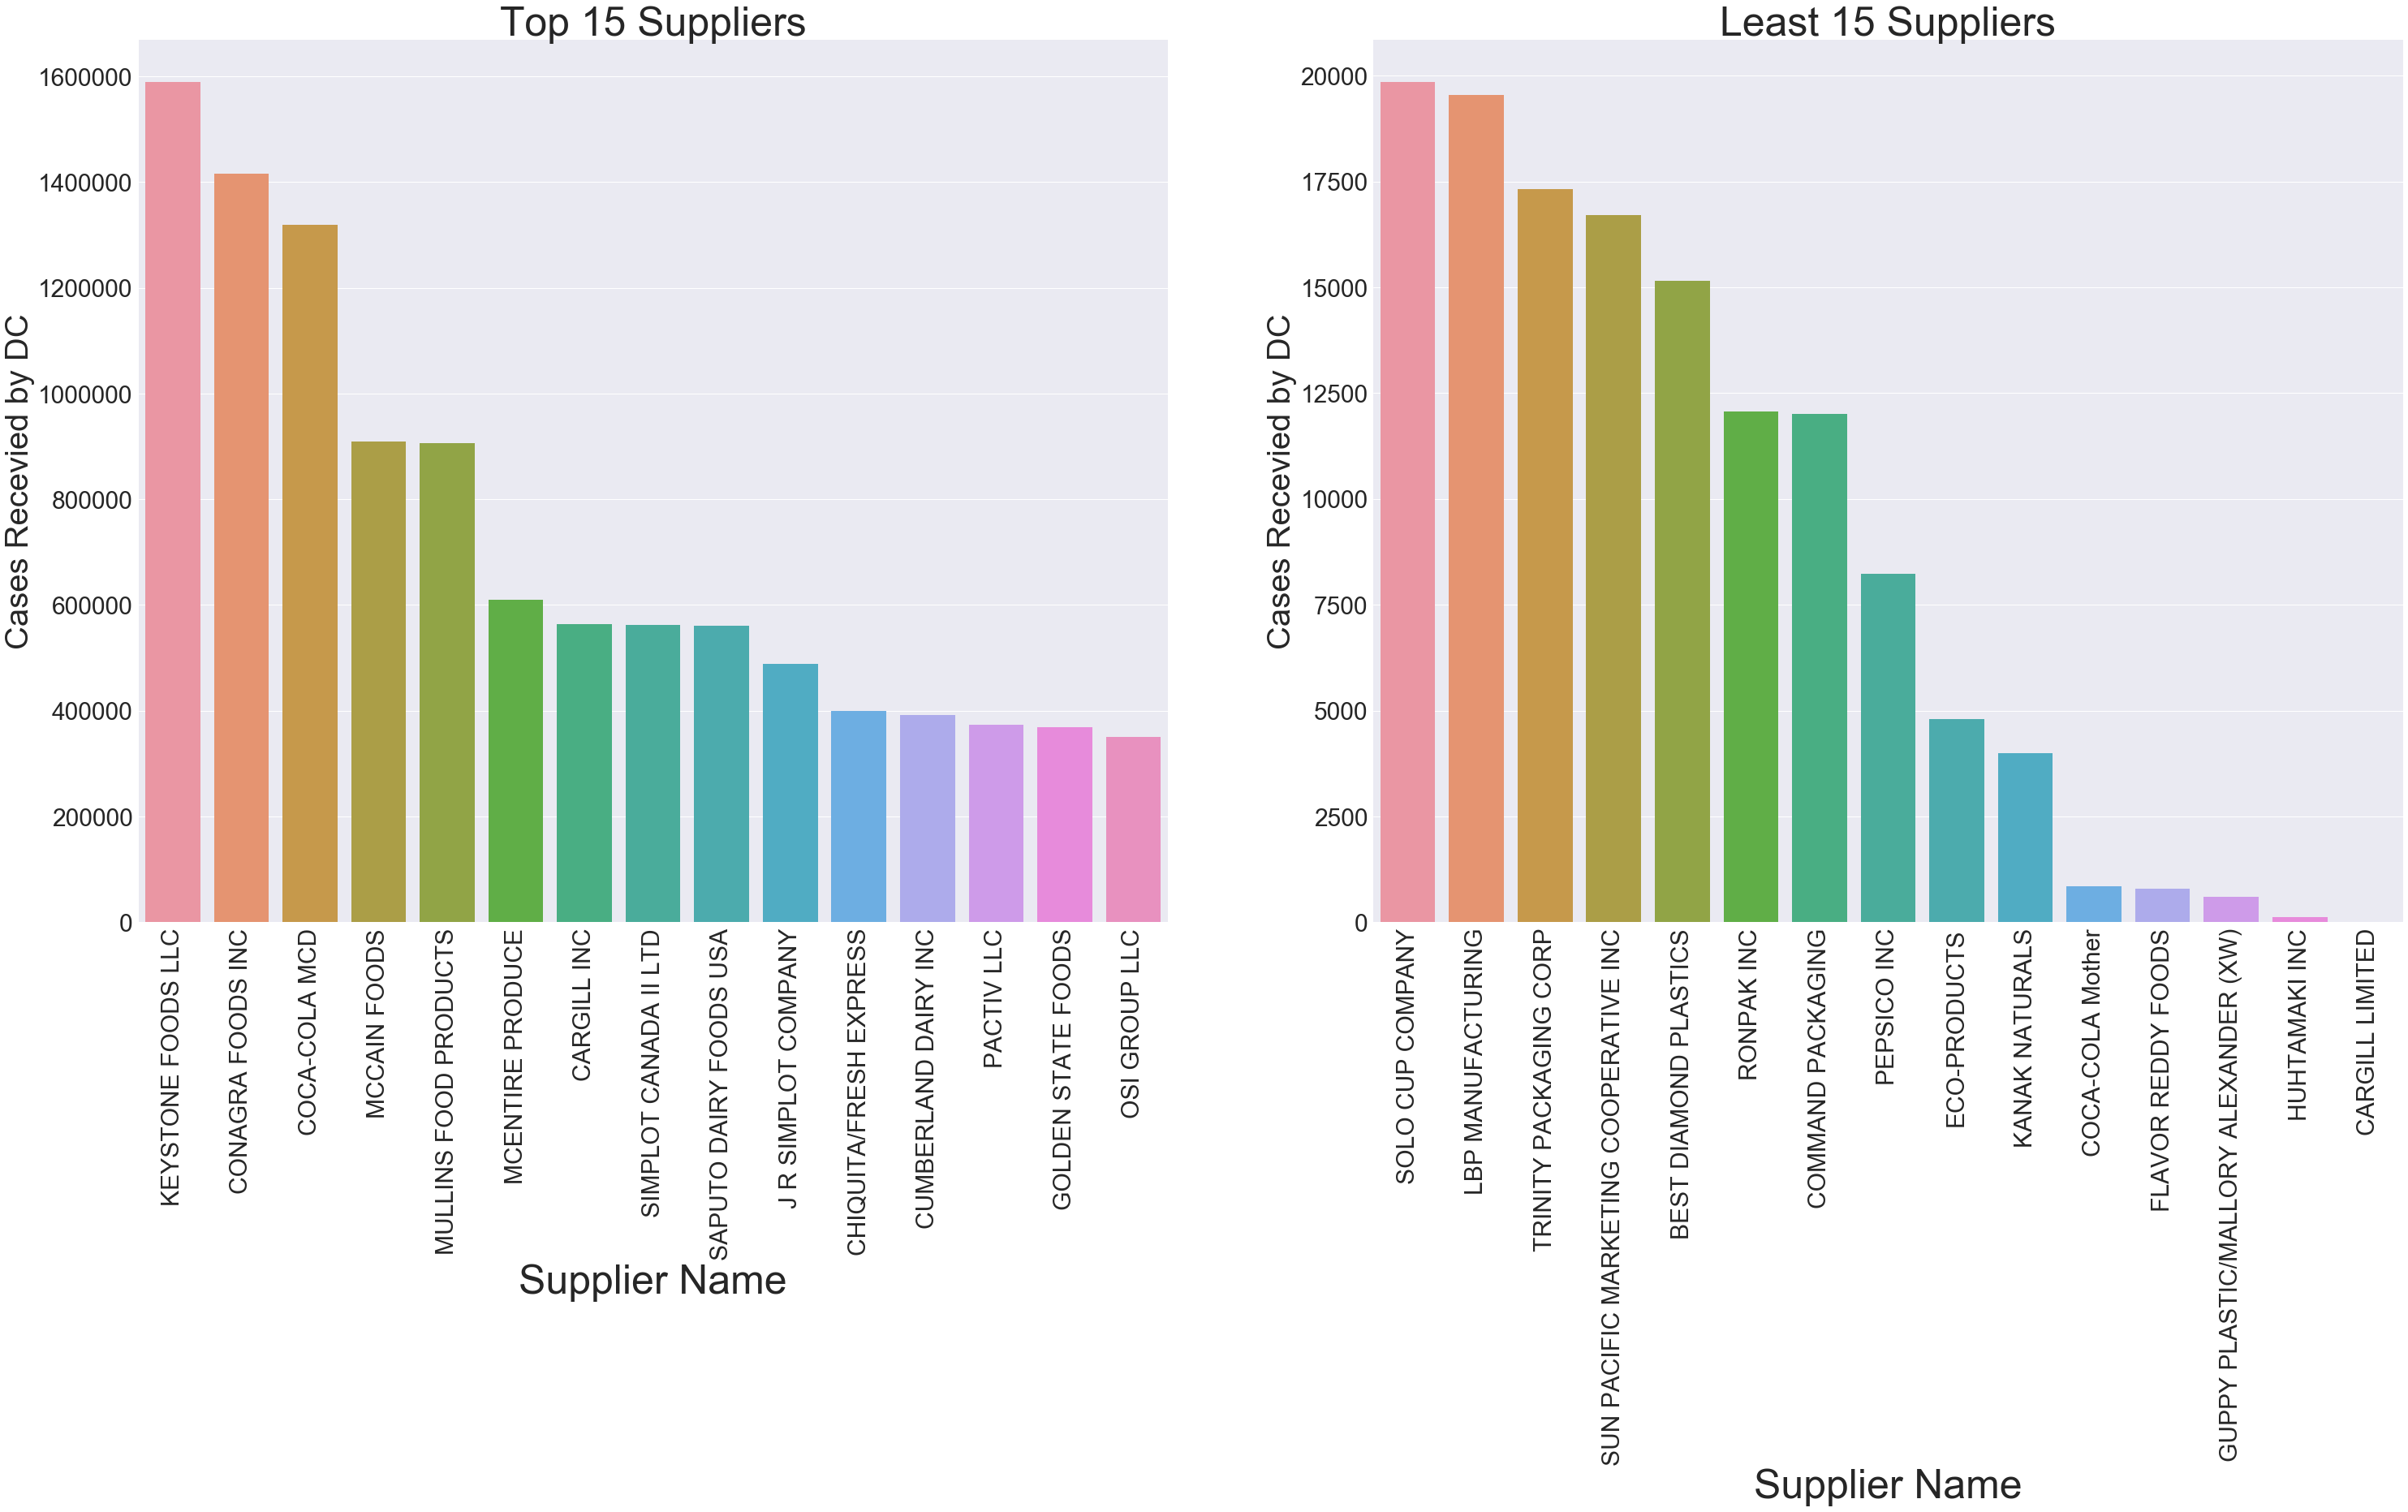

In [17]:
#Top and least suppliers for Mcdonalds
#plt.figure()

plt.figure(figsize=(50,20))
plt.subplot(121)

df = DC_Volume[['Supplier Parent Name','DC Receipts Cases Received']]
df['Supplier Parent Name']=df['Supplier Parent Name'].replace(['COCA-COLA COMPANY (THE)/MCDONALDS ACCOUNT GROUP'],value='COCA-COLA MCD')
df['Supplier Parent Name']=df['Supplier Parent Name'].replace(['COCA-COLA COMPANY (THE)/MOTHER PARKERS FOODS LTD'],value='COCA-COLA Mother')
grouped = df.groupby(df['Supplier Parent Name']).sum().reset_index()
grouped = grouped.sort_values('DC Receipts Cases Received', ascending = False)
sns.barplot(grouped['Supplier Parent Name'][:15], grouped['DC Receipts Cases Received'][:15])
plt.title("Top 15 Suppliers",size=50)
plt.ylabel("Cases Recevied by DC",size=40)
plt.xticks(rotation=90,size=30)
plt.yticks(size=30)
plt.xlabel('Supplier Name',size=50)

plt.subplot(122)
sns.barplot(grouped['Supplier Parent Name'][-15:], grouped['DC Receipts Cases Received'][-15:])
plt.title("Least 15 Suppliers",size=50)
plt.ylabel("Cases Recevied by DC",size=40)
plt.xticks(rotation=90,size=30)
plt.yticks(size=30)
plt.xlabel('Supplier Name',size=50)
plt.show()
